In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')
from hms_pipeline.project_configs import HMS_CONFIG

from hms_pipeline.eeg1d_dataset import Eeg1dDataset, load_raw_eeg, get_sub_raw_eeg
from hms_pipeline.eeg_model import EEGNet

/home/maxc/miniconda3/envs/unet-seg/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/maxc/miniconda3/envs/unet-seg/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit 

In [2]:
test_eeg_id = 1628180742
# test_eeg_id = 2277392603
# test_eeg_id = 582999
# test_eeg_id = 642382
test_eeg_dir = "/home/maxc/workspace/kaggle-hms/hms-harmful-brain-activity-classification/train_eegs"

eeg_df = load_raw_eeg(test_eeg_id, test_eeg_dir)
print(eeg_df.shape)
print(eeg_df.head())

(18000, 18)
      Fp1_F7      F7_T3      T3_T5      T5_O1     Fp1_F3      F3_C3  \
0  39.810005 -31.709999  13.129997   2.739998  -9.979996   9.570000   
1  40.320000 -29.949997  13.440002  -4.529999 -10.119995  11.430000   
2  37.290001 -30.010002  12.099998  -2.769997  -4.339996   6.180000   
3  36.700005 -26.660004  10.620003  -5.090004  -9.370003  12.140007   
4  39.390007 -27.100006  15.739998 -17.500000  -9.779999  12.209999   

       C3_P3      P3_O1      Fz_Cz     Cz_Pz     Fp2_F4      F4_C4      C4_P4  \
0  28.639999  -4.260002  -8.739998  6.650002  10.840004  23.290001  -4.010002   
1  25.909996  -7.939995  -6.779999  3.729996   0.489998  30.620003 -11.750000   
2  23.959999  -9.190002 -20.320000 -8.250000   5.149994  22.940002 -14.180000   
3  21.489998  -8.690002 -11.779999 -7.019997   1.989998  24.549995 -13.879997   
4  20.870003 -12.770004  -5.320007 -3.829994  -6.370003  26.709999 -15.839996   

      P4_O2     Fp2_F8     F8_T4      T4_T6      T6_O2  
0 -1.660004  17.9

(18000, 18)
(288, 2000)
(288, 2000)
-3.0027256 3.4915152


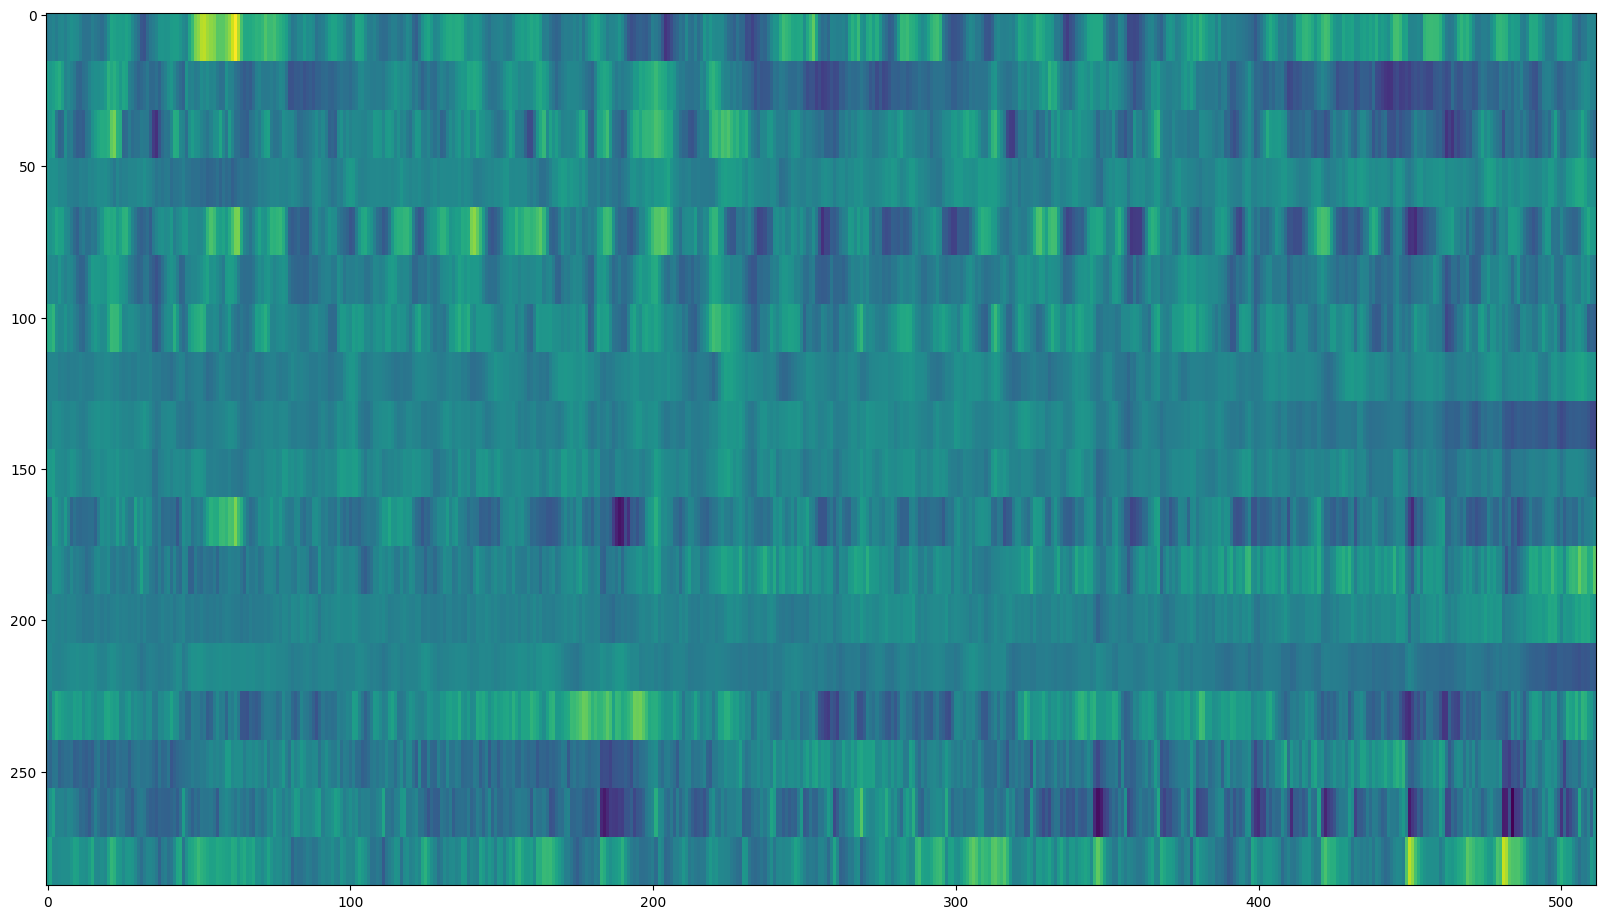

In [3]:
# normalize each column
import numpy as np
# for col in eeg_df.columns:
    # eeg_df[col] = (eeg_df[col] - eeg_df[col].mean()) / eeg_df[col].std()


data = eeg_df.values


ep = 1e-5
m = np.nanmean(data, axis = 0)
s = np.nanstd(data, axis =0)
data = (data - m)/(s+ep)
print(data.shape)
data = data[ 4000:6000,:]
data = data.T

data = np.repeat(data, 16, axis=0)

print(data.shape)
import cv2

plt.figure(figsize=(20, 220))
img = cv2.resize(data, (512, 18*16))
print(data.shape)
print(data.min(), data.max())
plt.imshow(img)

In [4]:
def display_eeg(eeg_df):
    offset = 0
    columns = eeg_df.columns
    plt.figure(figsize=(20, 10))
    for idx, col in enumerate(columns):
        offset += eeg_df[col].max()
        plt.plot(eeg_df[col] - offset, label=col)
        offset -= eeg_df[col].min()
    plt.legend()
    plt.show()


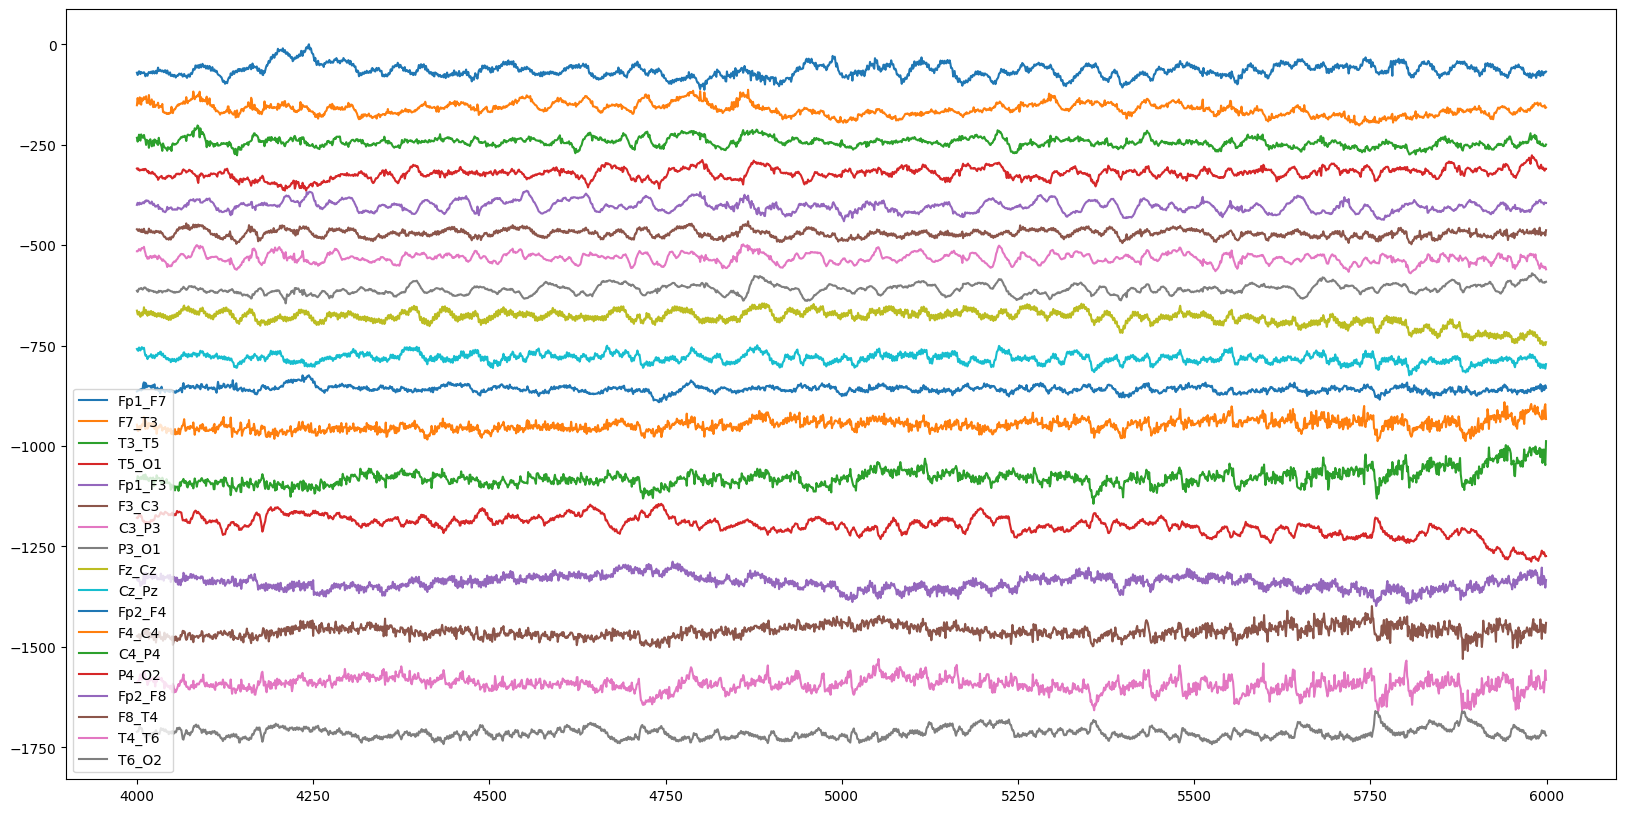

In [5]:
cropped_eeg_df = eeg_df.iloc[4000:6000]
display_eeg(cropped_eeg_df)

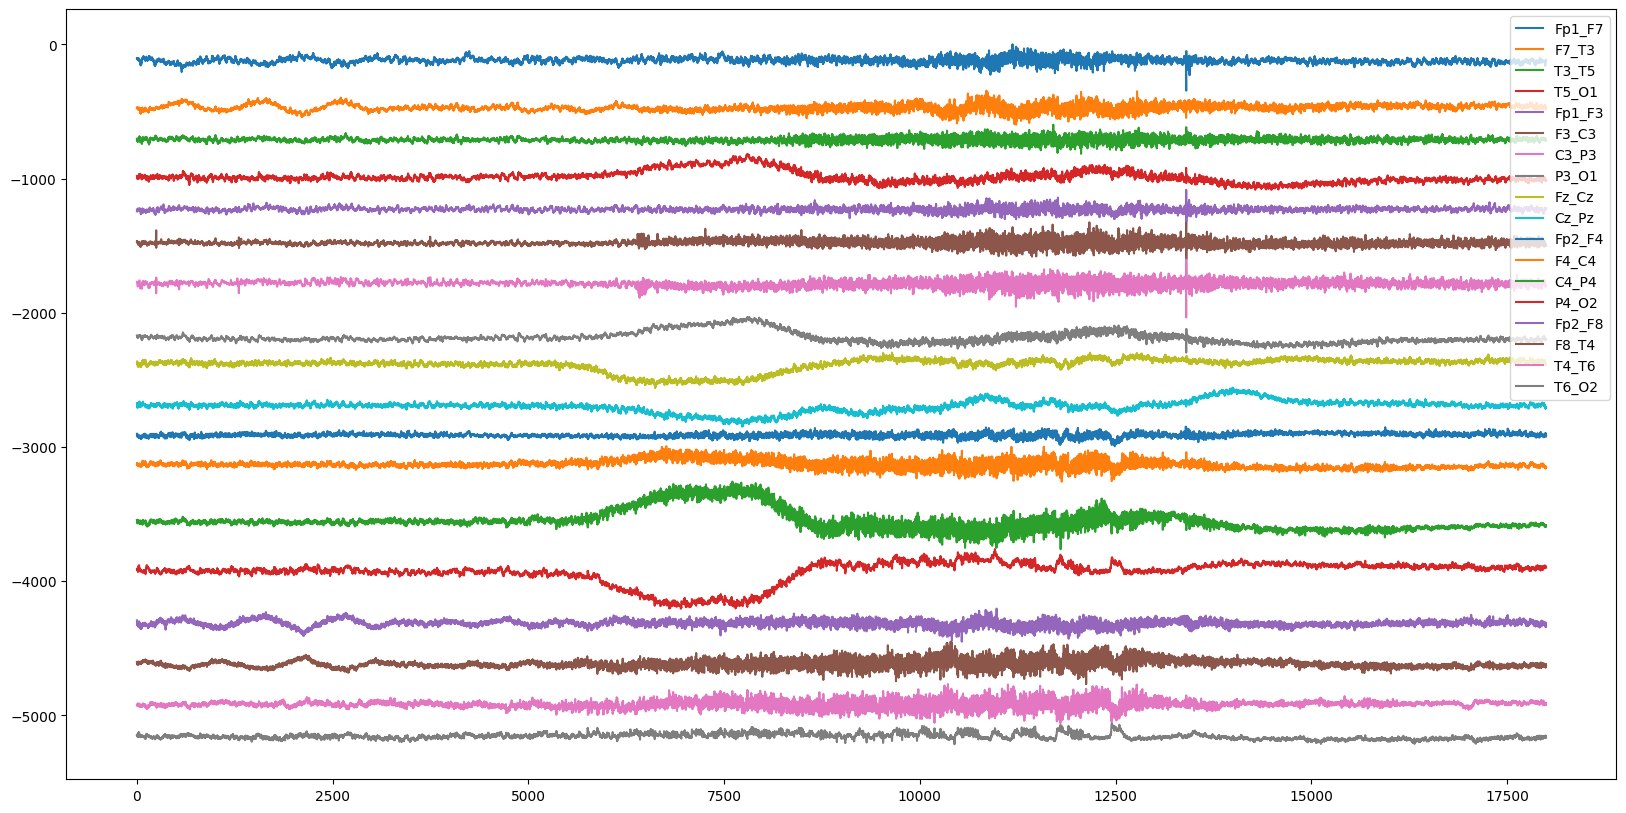

In [6]:
display_eeg(eeg_df)

(10000, 18)


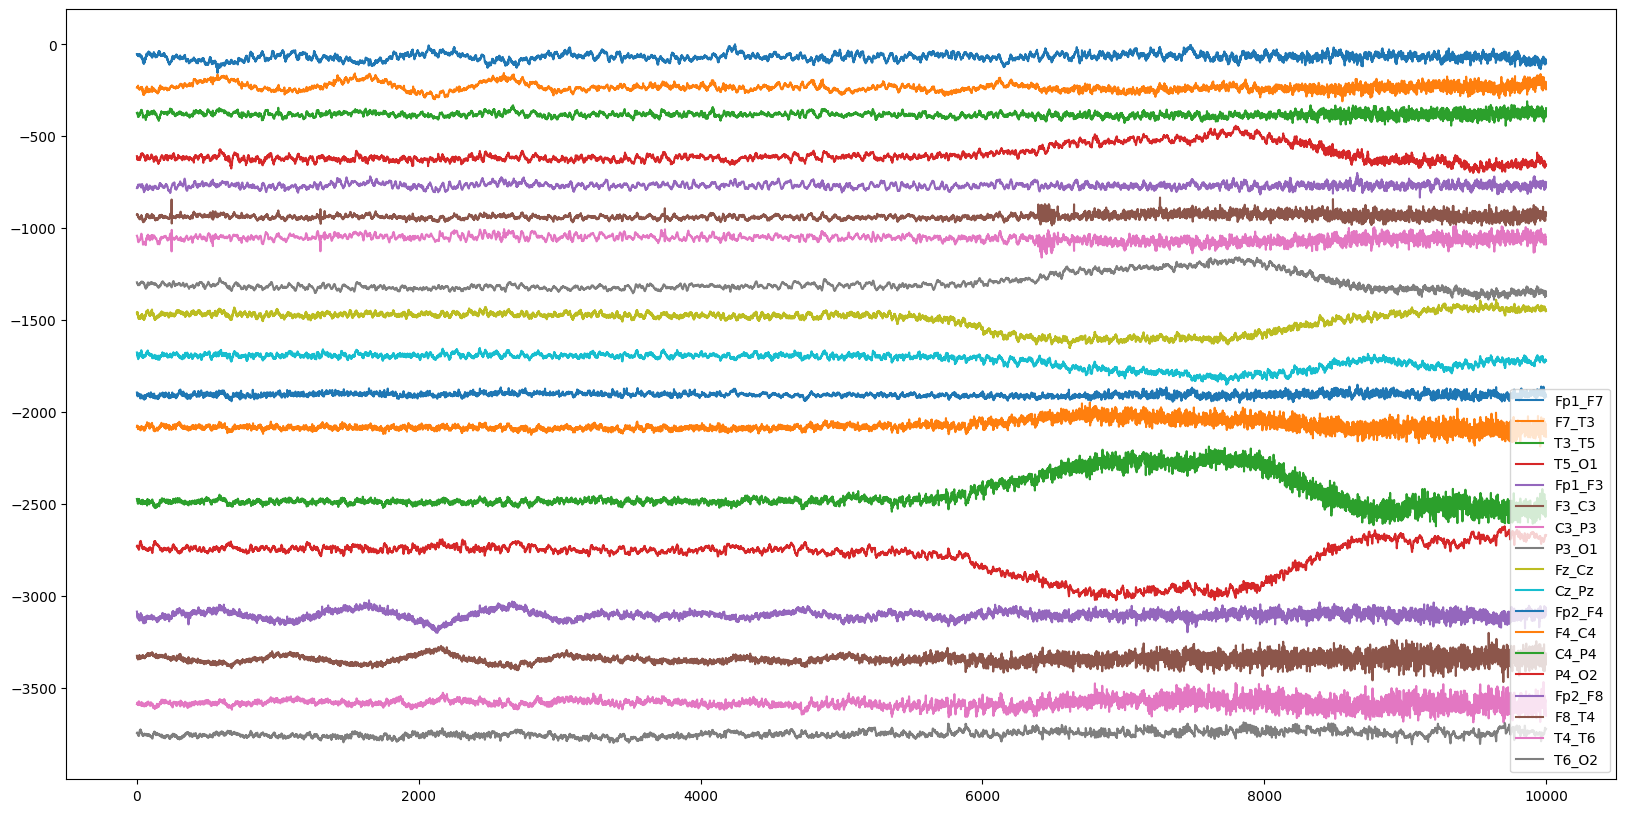

In [7]:
sub_eeg_df = get_sub_raw_eeg(eeg_df, 0)
print(sub_eeg_df.shape)
display_eeg(sub_eeg_df)

In [8]:
import torch
num_channels = 18
iot = torch.randn(2, 18, 10000)#.cuda()
model = EEGNet(kernels=[3,5,7,9], in_channels=18, fixed_kernel_size=5, num_classes=6)#.cuda()
output = model(iot)
print(output.shape)
print(output)
print(torch.softmax(output, dim=1))

torch.Size([2, 6])
tensor([[-0.1634, -0.1512,  0.0683, -0.1527,  0.1530,  0.0959],
        [-0.1774, -0.1815,  0.3470,  0.0706,  0.1289,  0.2609]],
       grad_fn=<AddmmBackward0>)
tensor([[0.1438, 0.1456, 0.1814, 0.1454, 0.1974, 0.1864],
        [0.1270, 0.1265, 0.2145, 0.1627, 0.1725, 0.1968]],
       grad_fn=<SoftmaxBackward0>)


In [9]:
import pandas as pd
train_df = pd.read_csv("/home/maxc/workspace/kaggle-hms/hms-harmful-brain-activity-classification/train.csv")
raw_eeg_dir = "/home/maxc/workspace/kaggle-hms/hms-harmful-brain-activity-classification/train_eegs"

dataset = Eeg1dDataset(train_df,raw_eeg_dir, sub_sample=True)

In [10]:
for i in range(5):
    sample = dataset[i]
    eeg = sample['eeg']
    meta = sample['metadata']
    label = sample['label']
    print(label)
    print(meta)
    print(eeg.shape)
    # print the type of the sample
    # plt.subplot(1, 5, i+1)
    # plt.imshow(spec[0])

[0.         0.         0.25       0.         0.16666667 0.5833333 ]
{'eeg_id': 568657, 'eeg_sub_id': 1, 'eeg_label_offset_seconds': 6.0, 'spectrogram_id': 789577333, 'spectrogram_sub_id': 1, 'spectrogram_label_offset_seconds': 6.0, 'label_id': 3640441665, 'patient_id': 20654, 'expert_consensus': 'Other', 'seizure_vote': 0, 'lpd_vote': 0, 'gpd_vote': 3, 'lrda_vote': 0, 'grda_vote': 2, 'other_vote': 7}
(18, 10000)
[0.         0.85714287 0.         0.07142857 0.         0.07142857]
{'eeg_id': 582999, 'eeg_sub_id': 8, 'eeg_label_offset_seconds': 24.0, 'spectrogram_id': 1552638400, 'spectrogram_sub_id': 8, 'spectrogram_label_offset_seconds': 24.0, 'label_id': 129939089, 'patient_id': 20230, 'expert_consensus': 'LPD', 'seizure_vote': 0, 'lpd_vote': 12, 'gpd_vote': 0, 'lrda_vote': 1, 'grda_vote': 0, 'other_vote': 1}
(18, 10000)
[0. 0. 0. 0. 0. 1.]
{'eeg_id': 642382, 'eeg_sub_id': 0, 'eeg_label_offset_seconds': 0.0, 'spectrogram_id': 14960202, 'spectrogram_sub_id': 12, 'spectrogram_label_offse